In [1]:
from typing import Dict, List, Tuple, Union, Sequence, Optional
from collections import defaultdict
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

def plot_f1_comparison(
    experiment_dirs: Sequence[Union[str, Path]],
    f1_key: str = "coco/bbox_mF1",
    target_steps: Tuple[int, ...] = (12, 24, 36),
    step_key_preference: str = "epoch",
    log_labels: Optional[Union[List[str], Dict[Union[str, Path], str]]] = None,
    show: bool = True,
    save_path: Optional[Union[str, Path]] = None,
    dpi: int = 120,
    figsize: Tuple[float, float] = (12, 7),
    bar_width_scale: float = 0.8
):
    """
    Plots F1 scores for a set of experiment directories as a grouped horizontal bar chart.
    For each directory, it calculates the mean and std dev of F1 scores over multiple runs.
    Each group of bars represents an experiment, and each bar within a group
    represents the mean F1 score at a specific target step, with error bars for std dev.

    Parameters
    ----------
    experiment_dirs : sequence of str or Path
        Directories containing experiment runs. Each subdirectory with a timestamp is a run.
    f1_key : str
        Key to look up in each JSON line for F1 score.
    target_steps : tuple of int
        Which steps/epochs to sample from each log.
    step_key_preference : {"epoch", "step"}
        When both keys exist, which one to treat as the canonical step index.
    log_labels : list/tuple OR dict OR None
        Custom labels for experiments. If None, directory names are used.
    show : bool
        If True, call plt.show().
    save_path : str or Path or None
        If given, saves the figure here.
    dpi : int
        DPI for the saved/shown figure.
    figsize : tuple
        Figure size for the plot.
    bar_width_scale : float
        Scaling factor for the height of the bars.
    """

    # ---------- helper to resolve a label for a directory --------------------
    def _label_for(idx: int, d: Union[str, Path]) -> str:
        d_path = Path(d)
        if log_labels is None:
            return d_path.name
        if isinstance(log_labels, (list, tuple)):
            try:
                return log_labels[idx]
            except IndexError:
                return d_path.name
        # dict-like
        return log_labels.get(d, log_labels.get(d_path.name, d_path.name))

    # ---------- collect data -----------------------------------------------
    target_steps_set = set(target_steps)
    stats_data = defaultdict(lambda: {s: [] for s in target_steps_set})

    for dir_idx, exp_dir in enumerate(experiment_dirs):
        exp_dir_path = Path(exp_dir)
        log_files = list(exp_dir_path.glob('*/vis_data/scalars.json'))
        if not log_files:
            print(f"[WARN] No log files found in subdirectories of {exp_dir}")
            continue

        for file_path in log_files:
            found_in_file: Dict[int, float] = {}
            try:
                with file_path.open() as fh:
                    for line in fh:
                        try:
                            rec = json.loads(line)
                        except json.JSONDecodeError:
                            continue

                        step_val = rec.get(step_key_preference) or rec.get("epoch") or rec.get("step")
                        if step_val not in target_steps_set:
                            continue

                        if f1_key in rec:
                            found_in_file[step_val] = rec[f1_key]
            except FileNotFoundError:
                continue

            for s in target_steps_set:
                if s in found_in_file:
                    stats_data[dir_idx][s].append(found_in_file[s])

    # ---------- plotting ----------------------------------------------------
    n_dirs = len(experiment_dirs)
    if n_dirs == 0:
        print("[INFO] nothing to plot."); return
        
    n_steps = len(target_steps)
    sorted_target_steps = sorted(list(target_steps_set))

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    bar_height = (1.0 / (n_steps + 1.5)) * bar_width_scale
    indices = np.arange(n_dirs)

    cmap = plt.cm.get_cmap("tab10")

    all_means_for_xlim = []

    for i, step_val in enumerate(sorted_target_steps):
        means = []
        stds = []
        for dir_idx in range(n_dirs):
            f1_scores = stats_data[dir_idx].get(step_val, [])
            if f1_scores:
                means.append(np.mean(f1_scores))
                stds.append(np.std(f1_scores))
            else:
                means.append(np.nan)
                stds.append(np.nan)
        
        all_means_for_xlim.extend(m for m in means if not np.isnan(m))

        offset = (i - (n_steps - 1) / 2) * bar_height
        
        rects = ax.barh(indices + offset, means, bar_height, xerr=stds,
                       label=f"Step {step_val}", color=cmap(i),
                       edgecolor="k", linewidth=0.5, capsize=3)
        
        # Add text labels inside bars
        for rect_idx, rect in enumerate(rects):
            width = rect.get_width()
            if not np.isnan(width) and width > 0:
                ax.text(width - 0.005, rect.get_y() + rect.get_height() / 2.,
                        f'{width:.3f}',
                        ha='right', va='center', fontsize=7, color='white', weight='bold')

    processed_log_labels = [_label_for(i, d) for i, d in enumerate(experiment_dirs)]

    ax.set_xlabel(f1_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_title(f"Mean {f1_key} Comparison at Steps {', '.join(map(str, sorted_target_steps))}")
    
    ax.set_yticks([])
    ax.tick_params(axis='y', length=0)

    # Add experiment labels horizontally, but positioned vertically above each bar group
    for dir_idx, label in enumerate(processed_log_labels):
        # Position the label in the space 'above' the bar group (smaller y with inverted axis)
        label_y_pos = indices[dir_idx] - 0.35
        ax.text(0.001, label_y_pos, label, ha='left', va='center', fontsize=9, weight='bold')

    max_overall_mean = max(all_means_for_xlim) if all_means_for_xlim else 0
    ax.set_xlim(left=0, right=max_overall_mean * 1.15)

    ax.legend(title="Step", loc="best", fontsize="small")
    ax.grid(True, linestyle="--", alpha=0.6, axis='x')
    ax.invert_yaxis()  # Invert y-axis to have the first experiment at the top
    
    # Adjust Y-axis limits to make space for the labels above the top bars
    ax.set_ylim(n_dirs - 0.5, -1)
    
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)

/tmp/ipykernel_18157/2139458096.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


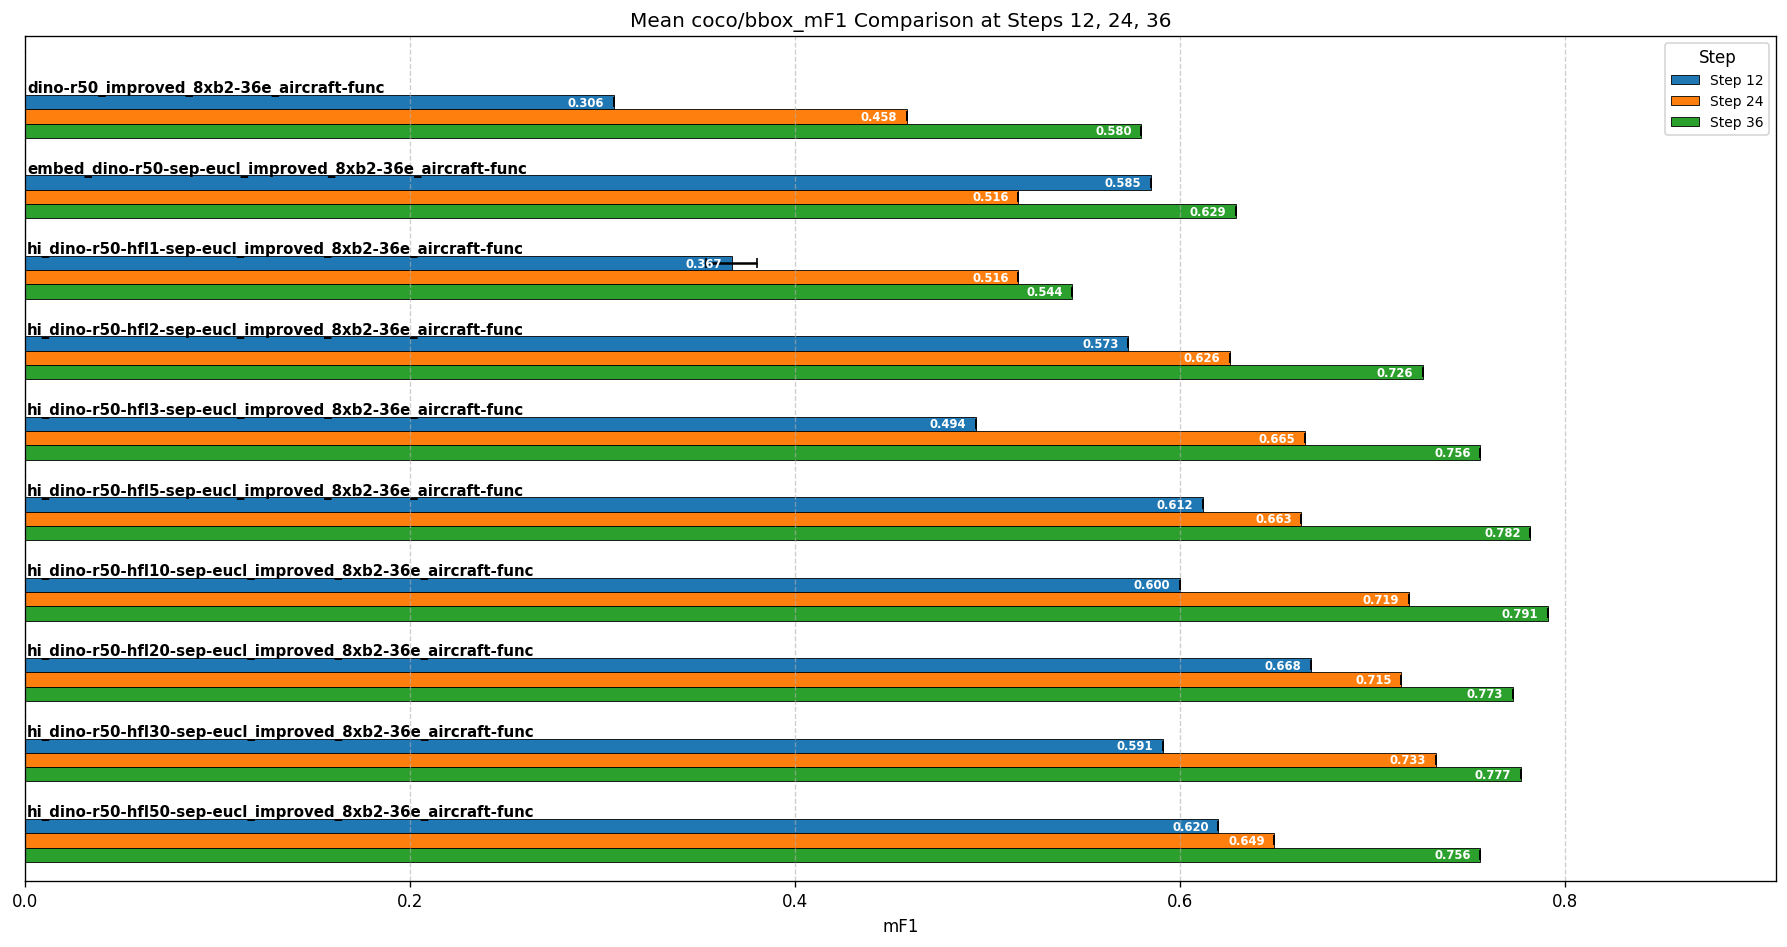

In [2]:
# Example usage of the new plot_f1_comparison function
experiment_dirs_to_compare = [
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func",
    "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl1-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl2-sep-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl3-ecl-sep-raw-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl3-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl5-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl20-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl30-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl50-sep-eucl_improved_8xb2-36e_aircraft-func",
]
plot_f1_comparison(
    experiment_dirs=experiment_dirs_to_compare,
    f1_key="coco/bbox_mF1",
    target_steps=[12, 24, 36],
    figsize=(15, 8),
    show=True
)

In [1]:
import os
import glob
from pathlib import Path
import json, matplotlib.pyplot as plt, numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple, Union, Sequence, Optional

def plot_precision_recall_comparison(
    experiment_dirs: Sequence[Union[str, Path]],
    map_key: str = "coco/bbox_mAP",
    mar_key: str = "coco/bbox_AR@100",
    target_steps: Tuple[int, ...] = (12, 24, 36),
    step_key_preference: str = "epoch",
    log_labels: Optional[Union[List[str], Dict[Union[str, Path], str]]] = None,
    show: bool = True,
    save_path: Optional[Union[str, Path]] = None,
    dpi: int = 120,
    figsize: Tuple[float, float] = (10, 7),
):
    """
    Scatter-plots mAP (x-axis) against mAR (y-axis) for a set of experiment directories.
    For each directory, it calculates the mean and std dev of metrics over multiple runs.

    Parameters
    ----------
    experiment_dirs : sequence of str or Path
        Directories containing experiment runs. Each subdirectory with a timestamp is a run.
    map_key, mar_key : str
        Keys to look up in each JSON line for mAP and mAR.
    target_steps : iterable of int
        Which steps/epochs to sample from each log.
    step_key_preference : {"epoch", "step"}
        When both keys exist, which one to treat as the canonical step index.
    log_labels : list/tuple OR dict OR None
        Custom labels for experiments. If None, directory names are used.
    show : bool
        If True, call plt.show().
    save_path : str or Path or None
        If given, saves the figure here.
    dpi : int
        DPI for the saved/shown figure.
    figsize : tuple
        Figure size.
    """

    # ---------- helper to resolve a label for a directory --------------------
    def _label_for(idx: int, d: Union[str, Path]) -> str:
        d_path = Path(d)
        if log_labels is None:
            return d_path.name
        if isinstance(log_labels, (list, tuple)):
            try:
                return log_labels[idx]
            except IndexError:
                return d_path.name
        # dict-like
        return log_labels.get(d, log_labels.get(d_path.name, d_path.name))

    # ---------- collect points -----------------------------------------------
    target_steps_set = set(target_steps)
    stats_data = defaultdict(lambda: {s: {'map': [], 'mar': []} for s in target_steps_set})

    for dir_idx, exp_dir in enumerate(experiment_dirs):
        exp_dir_path = Path(exp_dir)
        log_files = list(exp_dir_path.glob('*/vis_data/scalars.json'))
        if not log_files:
            print(f"[WARN] No log files found in subdirectories of {exp_dir}")
            continue

        for file_path in log_files:
            found_in_file: Dict[int, Dict[str, float]] = {s: {} for s in target_steps_set}
            try:
                with file_path.open() as fh:
                    for line in fh:
                        try:
                            rec = json.loads(line)
                        except json.JSONDecodeError:
                            continue

                        step_val = rec.get(step_key_preference) or rec.get("epoch") or rec.get("step")
                        if step_val not in target_steps_set:
                            continue

                        if map_key in rec:
                            found_in_file[step_val][map_key] = rec[map_key]
                        if mar_key in rec:
                            found_in_file[step_val][mar_key] = rec[mar_key]
            except FileNotFoundError:
                continue

            for s in target_steps_set:
                if map_key in found_in_file[s] and mar_key in found_in_file[s]:
                    stats_data[dir_idx][s]['map'].append(found_in_file[s][map_key])
                    stats_data[dir_idx][s]['mar'].append(found_in_file[s][mar_key])

    # ---------- plotting -----------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    n_dirs = len(experiment_dirs)
    cmap = plt.cm.get_cmap("tab10")
    unique_steps = sorted(list(target_steps_set))
    markers = ["o", "s", "^", "D", "P", "X", "*", "v"]
    marker_for_step = {s: markers[i % len(markers)] for i, s in enumerate(unique_steps)}

    for dir_idx, exp_dir in enumerate(experiment_dirs):
        if dir_idx not in stats_data:
            continue

        line_points = []
        for step in unique_steps:
            map_vals = stats_data[dir_idx][step]['map']
            mar_vals = stats_data[dir_idx][step]['mar']

            if not map_vals or not mar_vals:
                continue

            mean_map, std_map = np.mean(map_vals), np.std(map_vals)
            mean_mar, std_mar = np.mean(mar_vals), np.std(mar_vals)

            ax.errorbar(mean_map, mean_mar, xerr=std_map, yerr=std_mar,
                        marker=marker_for_step[step],
                        markersize=8,
                        color=cmap(dir_idx),
                        capsize=3,
                        linestyle='None',
                        elinewidth=1,
                        alpha=0.8,
                        zorder=5)
            line_points.append({'map': mean_map, 'mar': mean_mar, 'step': step})

        if line_points:
            line_points.sort(key=lambda p: p['step'])
            xs = [p['map'] for p in line_points]
            ys = [p['mar'] for p in line_points]

            ax.plot(xs, ys, linestyle="-", linewidth=1.0, alpha=0.3,
                    color=cmap(dir_idx), zorder=1)

    # -----------------------------------------------------------------------
    # ░░ Draw iso‑F1 (or Fβ) lines behind everything ░░
    # -----------------------------------------------------------------------
    f_levels = [0.3, 0.4, 0.5, 0.6, 0.7]        # tweak as you like
    ax.autoscale(enable=True, axis='both', tight=False)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    x_vals = np.linspace(xmin, xmax, 400)

    for F in f_levels:
        # domain starts at P = F/2
        p = x_vals[x_vals > F / 2 + 1e-6]
        r = (F * p) / (2 * p - F)

        # keep points that land inside current y‑axis limits
        ymask = (r >= ymin) & (r <= ymax)
        ax.plot(
            p[ymask],
            r[ymask],
            linestyle="--",
            linewidth=0.8,
            color="grey",
            alpha=0.4,
            zorder=0,           # far behind markers/lines
        )
        # label the curve on the right edge
        if ymask.any():
            ax.text(
                p[ymask][-1],
                r[ymask][-1],
                f"F1={F:.1f}",
                fontsize=8,
                color="grey",
                ha="left",
                va="center",
                alpha=0.6,
            )
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # -------- legend by step (markers) -----------------------------------------
    step_handles = [
        plt.Line2D([0], [0], marker=marker_for_step[s], linestyle="",
                markersize=8, color="w", markeredgecolor="k")
        for s in unique_steps
    ]
    step_labels = [f"step {s}" for s in unique_steps]

    step_legend = ax.legend(
        step_handles,
        step_labels,
        title="Epoch Step",
        loc="best",
        fontsize="small",
    )
    ax.add_artist(step_legend)

    # -------- legend by experiment (colours) ------------------------------------
    exp_handles = [
        plt.Line2D([0], [0], linestyle="-", color=cmap(i))
        for i in range(n_dirs) if i in stats_data
    ]
    exp_labels = [_label_for(i, experiment_dirs[i]) for i in range(n_dirs) if i in stats_data]

    ax.legend(
        exp_handles,
        exp_labels,
        title="Experiment",
        loc="lower right",
        fontsize="small",
    )

    ax.set_xlabel(map_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_ylabel(mar_key.replace("coco/", "").replace("bbox_", ""))
    ax.set_title(f"mAP vs mAR at steps {', '.join(map(str, unique_steps))}")
    ax.grid(True, linestyle="--", alpha=0.6)
    
    # Adjust layout to make room for the legend
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)


# Example usage:
# experiment_dirs_to_compare = [
#     "../work_dirs/dino-4scale_r50_improved_8xb2",
#     "../work_dirs/frozen-4scale_r50_improved_8xb2"
# ]
#
# plot_precision_recall_comparison(
#     experiment_dirs=experiment_dirs_to_compare,
#     target_steps=[12, 24, 36],
# )

/tmp/ipykernel_26231/3820655836.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


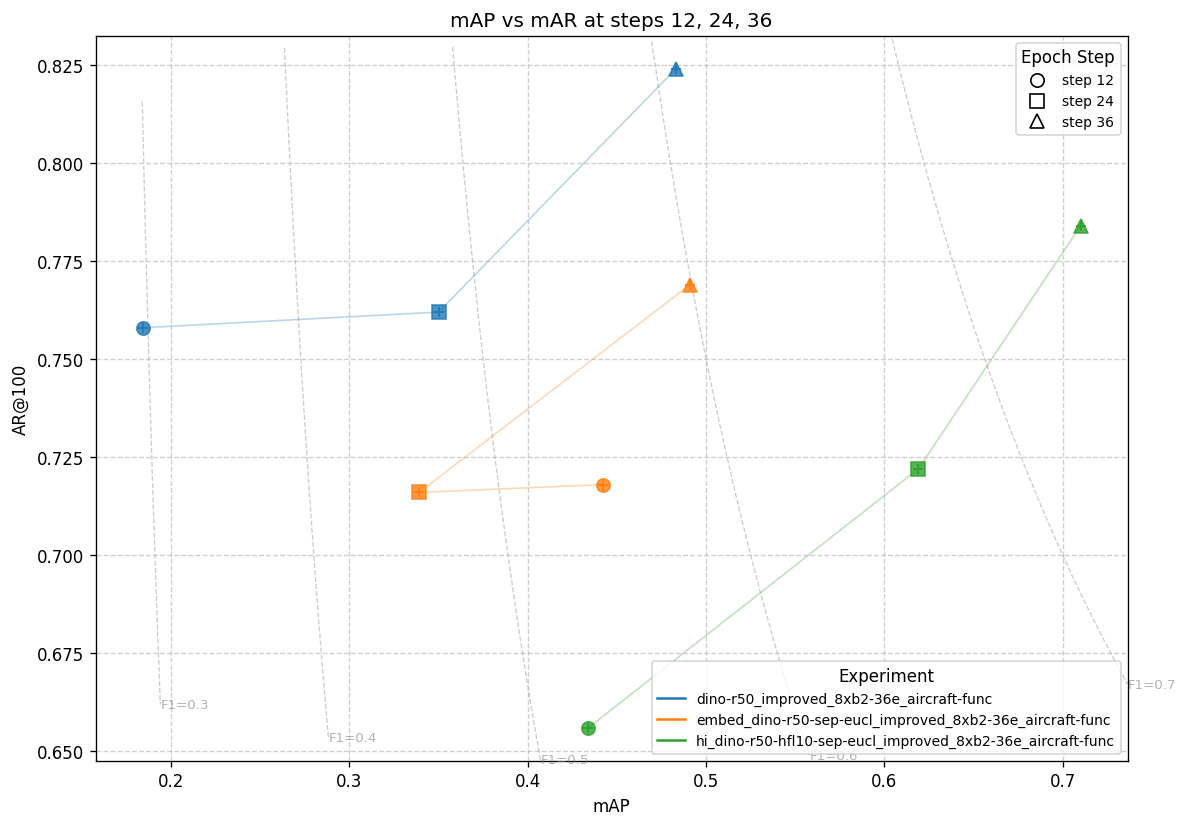

In [2]:
experiment_dirs_to_compare = [
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func",
    "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl1-sep-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl2-sep-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl3-ecl-sep-raw-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl3-sep-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl5-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl20-sep-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl30-sep-eucl_improved_8xb2-36e_aircraft-func",
    # "../work_dirs/hi_dino-r50-hfl50-sep-eucl_improved_8xb2-36e_aircraft-func",
]
plot_precision_recall_comparison(
    experiment_dirs=experiment_dirs_to_compare,
    target_steps=[12, 24, 36],
)

Info: Using proxy value 1000 for ../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func
Info: Using proxy value 1000 for ../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func


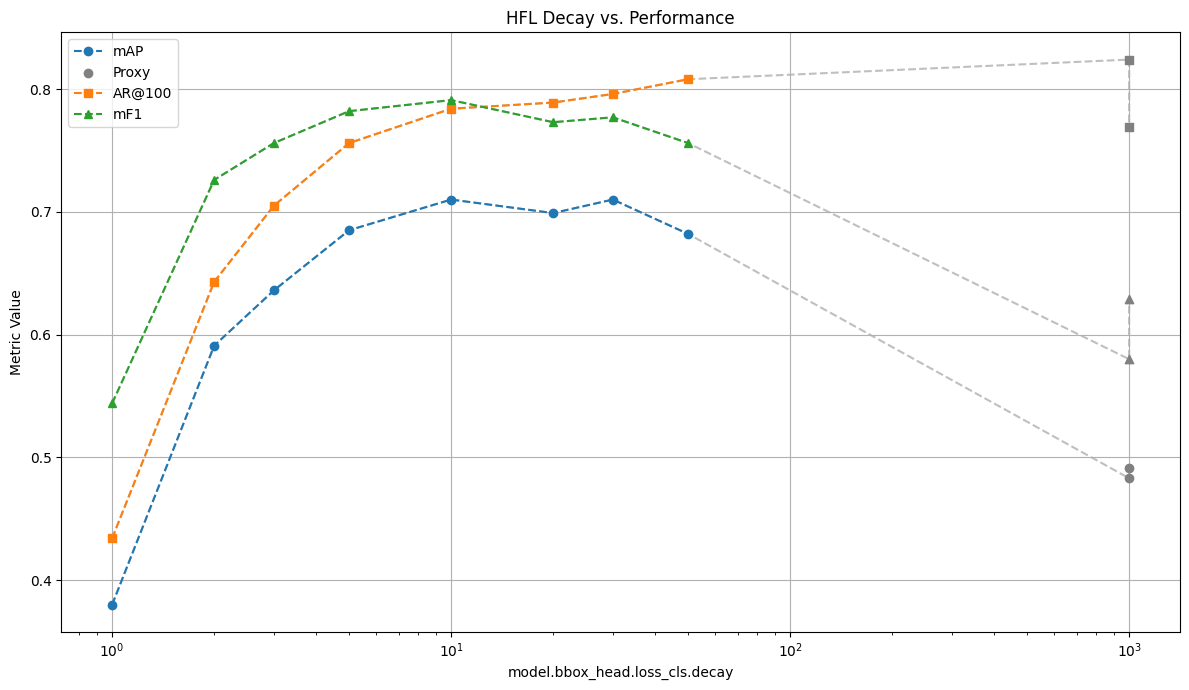

In [2]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mmengine import Config

def plot_config_vs_metrics(experiment_dirs, config_variable_path, metrics_to_track={'coco/bbox_mAP'}, title="Config vs. Metrics", use_log_scale=False, proxy_values=None):
    """
    Plots a configuration variable against final metric values from experiment logs.

    Args:
        experiment_dirs (list): A list of directories, where each directory contains one or more runs.
        config_variable_path (str): A dot-separated path to the variable in the config file (e.g., 'model.bbox_head.loss_cls.decay').
        metrics_to_track (set): A set of metric names to plot.
        title (str): The title of the plot.
        use_log_scale (bool): If True, sets the x-axis to a logarithmic scale.
        proxy_values (dict, optional): A dictionary mapping experiment directory paths to proxy values for the config variable.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    markers = ['o', 's', '^', 'D', '*']
    
    plot_data = {metric: [] for metric in metrics_to_track}

    for exp_dir in experiment_dirs:
        # Find the config file assuming it has the same name as the directory
        config_file = os.path.join(exp_dir, os.path.basename(exp_dir) + '.py')
        
        config_value = None
        is_proxy = False
        # Load config and extract variable
        try:
            if not os.path.exists(config_file):
                raise FileNotFoundError
            cfg = Config.fromfile(config_file)
            keys = config_variable_path.split('.')
            value = cfg
            for key in keys:
                value = getattr(value, key)
            config_value = value
        except (AttributeError, FileNotFoundError, SyntaxError) as e:
            if proxy_values and exp_dir in proxy_values:
                config_value = proxy_values[exp_dir]
                is_proxy = True
                print(f"Info: Using proxy value {config_value} for {exp_dir}")
            else:
                print(f"Warning: Could not read '{config_variable_path}' from {config_file}, skipping. Error: {e}")
                continue

        if config_value is None:
            print(f"Warning: No config value found or proxied for {exp_dir}, skipping.")
            continue

        # Find log files for all runs in the experiment directory
        log_files = glob.glob(os.path.join(exp_dir, '*/vis_data/scalars.json'))
        if not log_files:
            print(f"No log files found for {exp_dir}, skipping.")
            continue

        # Get the latest metric values from the first found log file
        # Note: This assumes the first log file is representative or the only one.
        log_file_to_use = log_files[0]
        final_metrics = {metric: None for metric in metrics_to_track}
        last_epoch = -1

        with open(log_file_to_use, "r") as f:
            for line in f:
                try:
                    data = json.loads(line)
                    epoch = data.get("epoch", data.get("step", None))
                    if epoch is None or epoch < last_epoch:
                        continue
                    last_epoch = epoch
                    for metric in metrics_to_track:
                        if metric in data:
                            final_metrics[metric] = data[metric]
                except json.JSONDecodeError:
                    continue
        
        for metric, value in final_metrics.items():
            if value is not None:
                plot_data[metric].append((config_value, value, is_proxy))

    # Plotting
    for i, (metric, points) in enumerate(plot_data.items()):
        if points:
            points = sorted(points, key=lambda x: x[0])
            config_values, metric_values, is_proxy_flags = zip(*points)
            
            label = metric.replace("coco/", "").replace("bbox_", "")
            
            # Plot gray line connecting all points first (as a background)
            ax.plot(config_values, metric_values, linestyle='--', color='gray', alpha=0.5, zorder=1)

            # Separate real and proxy points
            real_points = [(cv, mv) for cv, mv, proxy in zip(config_values, metric_values, is_proxy_flags) if not proxy]
            proxy_points = [(cv, mv) for cv, mv, proxy in zip(config_values, metric_values, is_proxy_flags) if proxy]

            marker = markers[i % len(markers)]
            
            # Plot real points with color and a connecting line
            if real_points:
                real_cv, real_mv = zip(*real_points)
                # The color will be automatically chosen by matplotlib's cycle
                line, = ax.plot(real_cv, real_mv, marker=marker, linestyle='--', label=label, zorder=2)
                # Use the same color for the scatter plot, which is now redundant with the marker in plot
                # ax.scatter(real_cv, real_mv, marker=marker, color=line.get_color(), zorder=3)

            # Plot proxy points in gray
            if proxy_points:
                proxy_cv, proxy_mv = zip(*proxy_points)
                # Add a label for proxy points only once
                proxy_label = "Proxy" if i == 0 else ""
                ax.scatter(proxy_cv, proxy_mv, marker=marker, color='gray', label=proxy_label, zorder=3)


    if use_log_scale:
        ax.set_xscale('log')

    ax.set_title(title)
    ax.set_xlabel(config_variable_path)
    ax.set_ylabel("Metric Value")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example Usage:
# This will plot the 'decay' hyperparameter vs. mAP and AR@100 for a set of experiments.
experiment_dirs_for_decay_plot = [
    "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func",
    "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl1-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl2-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl3-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl5-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl20-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl30-sep-eucl_improved_8xb2-36e_aircraft-func",
    "../work_dirs/hi_dino-r50-hfl50-sep-eucl_improved_8xb2-36e_aircraft-func",
]

plot_config_vs_metrics(
    experiment_dirs_for_decay_plot,
    config_variable_path='model.bbox_head.loss_cls.decay',
    metrics_to_track={"coco/bbox_mF1", "coco/bbox_mAP", "coco/bbox_AR@100"},
    title="HFL Decay vs. Performance",
    use_log_scale=True,
    proxy_values={
        "../work_dirs/dino-r50_improved_8xb2-36e_aircraft-func": 1000,
        "../work_dirs/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func": 1000
    }
)